In [1]:
# Parameters
symbol = '^GSPC'
start_date = '1970'

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [4]:
ty_rates = pd.read_csv("DGS10_clean.csv")
ty_rates.rename(columns={"DGS10": "rate", "DATE": "date"}, inplace=True)
ty_rates.rate /= 100.

ty_rates["date"] = pd.to_datetime(ty_rates["date"])

def ty_ret(rate, date):
    yr_date = date.dt.year.add(
        date.dt.dayofyear.sub(1)
        .div(date.dt.year + date.dt.is_leap_year)
    )    
    dt = yr_date.diff()
    resid = rate.add(1).pow(-10)
    ret = rate.shift().mul(1 - resid).div(rate).add(resid).sub(1)
    ret += rate.shift().mul(dt).div(1 + rate / np.e)  # no idea why
    return ret

ty_rates["ret"] = ty_ret(ty_rates.rate, ty_rates.date)
ty_rates = ty_rates.set_index("date")

In [5]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [6]:
# Note that when using ^GSPC, there are no dividends, and it's also 
# not really directly tradeable - I'll do a continuous futures version 
# at some point

# Rest of analysis assumes non-stock allocation is in cash, 
# but in reality you would have some gains from being in bonds as well

# We add transaction costs further down this sheet

sp_rets = data['Close'].transform(lambda xs: xs / xs.shift() - 1).rename('rets')

<AxesSubplot:xlabel='date'>

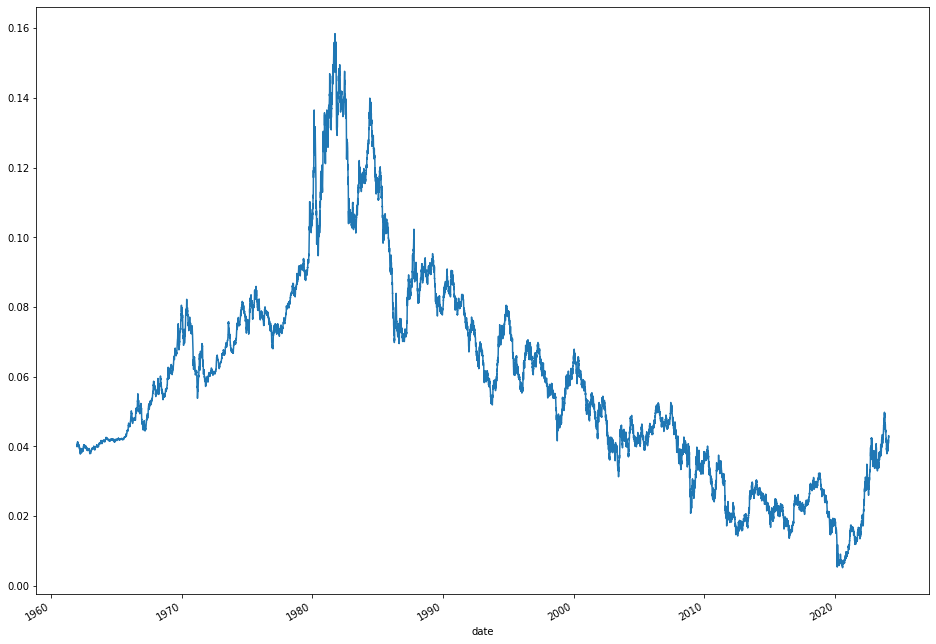

In [7]:
ty_rates.rate.plot()

In [8]:
bond_rets = ty_rates.ret
rets = sp_rets.add(bond_rets, fill_value=0).div(2)

In [9]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

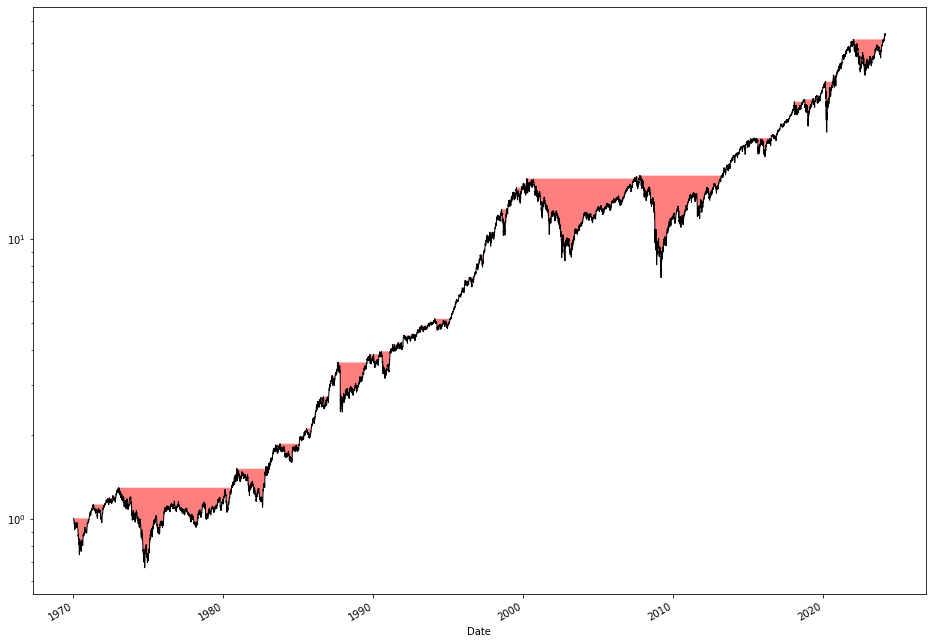

In [10]:
plot_dd(sp_rets)

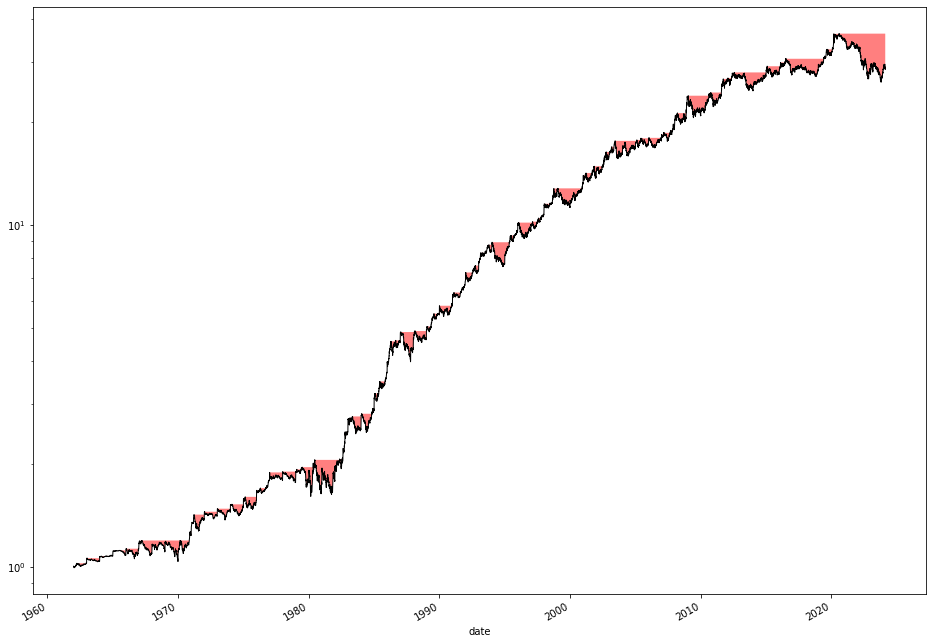

In [11]:
plot_dd(bond_rets)

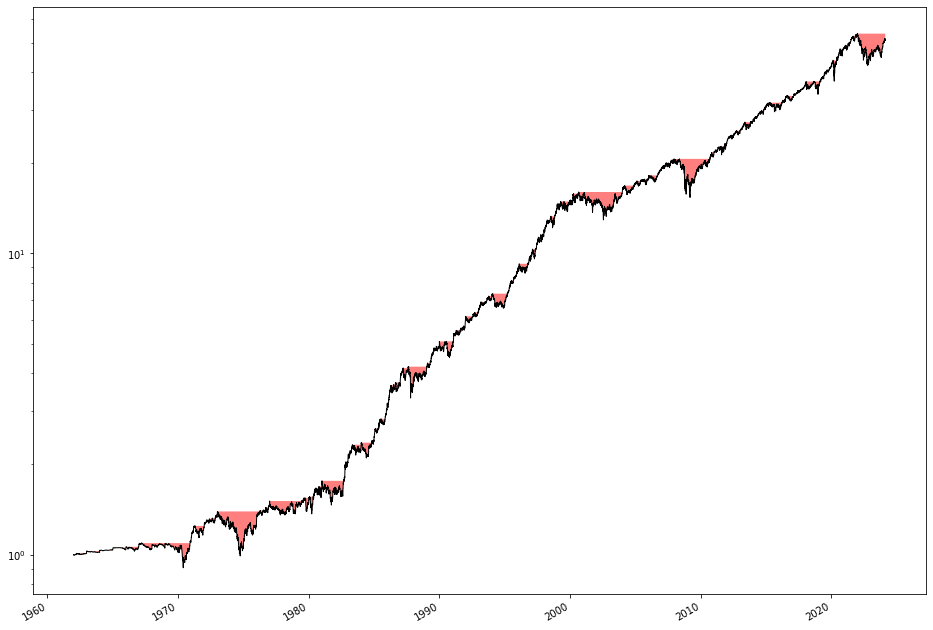

In [12]:
plot_dd(rets)

In [13]:
all_rets = pd.DataFrame({
    "sp500": sp_rets,
    "t_bonds": bond_rets,
}).dropna(subset="sp500").fillna(0)

<AxesSubplot:>

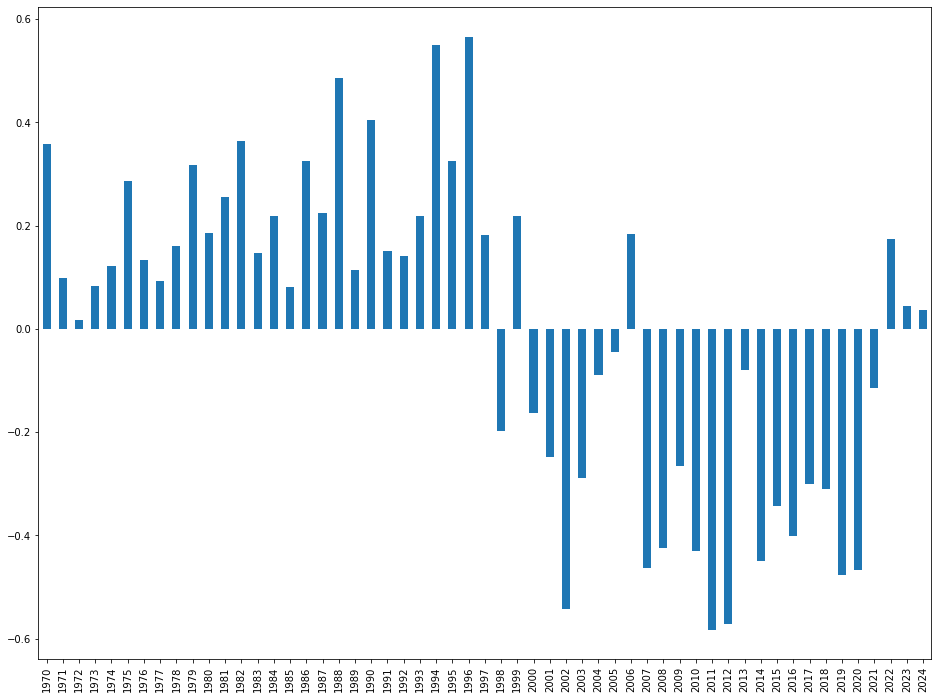

In [14]:
(
    all_rets
    .groupby(pd.Grouper(freq="Y"))
    .corr()
    .xs("sp500", level=1)["t_bonds"]
    .rename(index=lambda xs: xs.year)
    .plot.bar()
)

In [19]:
all_rets["port"] = all_rets.eval("(sp500 + t_bonds) / 2")

<AxesSubplot:>

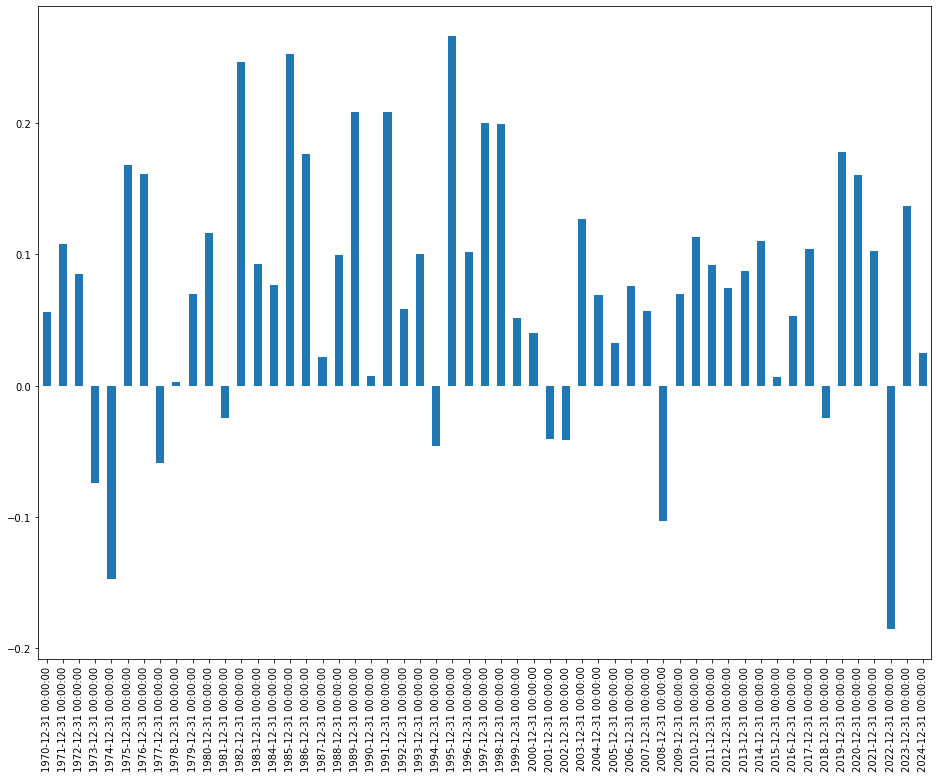

In [21]:
all_rets.port.groupby(pd.Grouper(freq="Y")).sum().plot.bar()

<AxesSubplot:>

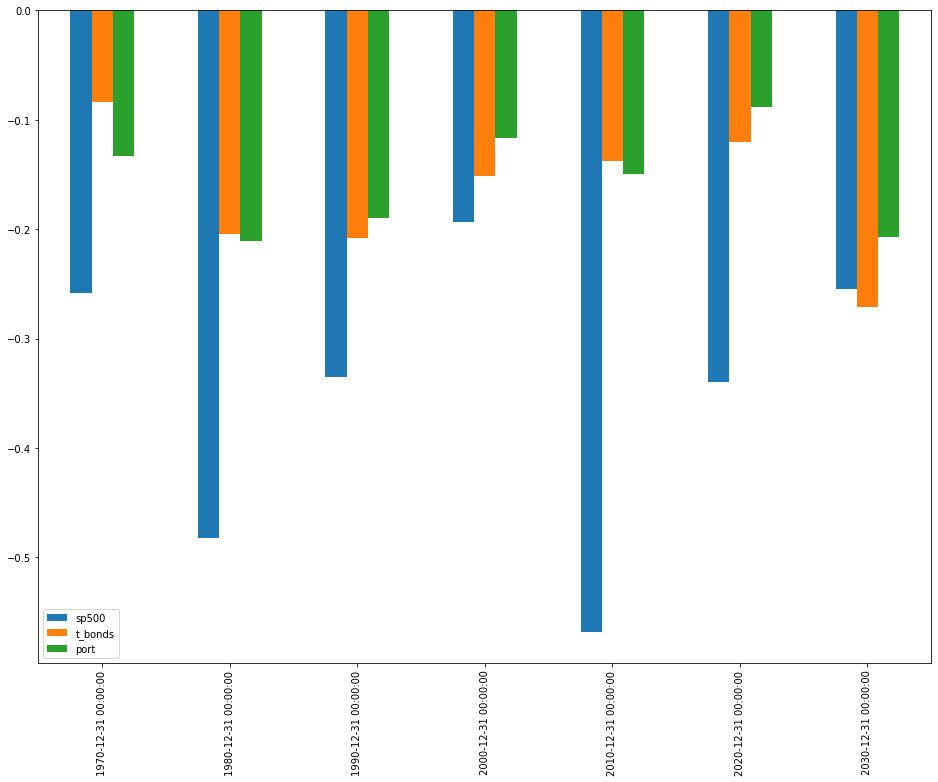

In [17]:
all_rets.add(1).cumprod().transform(lambda xs: xs / xs.cummax() - 1).groupby(pd.Grouper(freq="10Y")).min().plot.bar()

<AxesSubplot:>

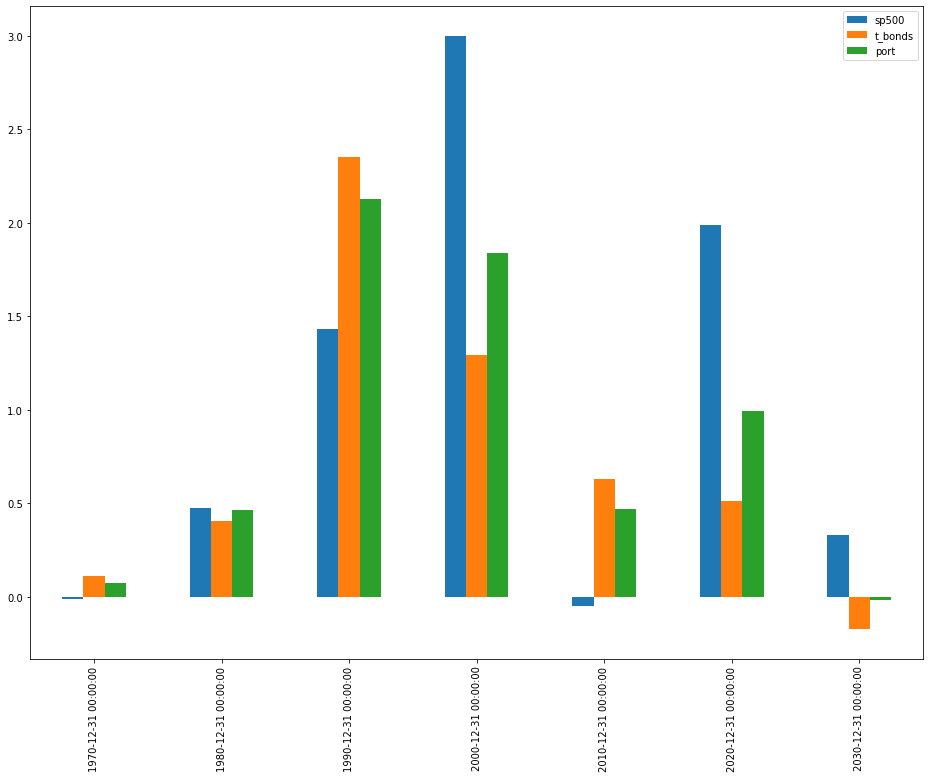

In [18]:
all_rets.add(1).groupby(pd.Grouper(freq="10Y")).prod().sub(1).plot.bar()